# Kalman Filter Validation

**Description**

This notebook validates the implementation of a Kalman filter for fractional Brownian motion (FBM) using the `kalman_filter` module. The validation process involves generating FBM data, applying the Kalman filter for filtering data with gaps and noise of varying intensity, and comparing the obtained data with the true values.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from StatTools.generators.kasdin_generator import KasdinGenerator

from StatTools.analysis.dfa import DFA

In [2]:
TRJ_LEN = 2**12
H_LIST = [round(i * 0.01, 2) for i in range(int(50), int(150) + 1, 25)]
print(H_LIST)

[0.5, 0.75, 1.0, 1.25, 1.5]


## Functions for adding noise and gaps

In [ ]:
def add_poisson_gaps(trajectory, gap_rate, length_rate):
    """
    Adds gaps to the trajectory according to the Poisson flow.

    Parameters:
    - trajectory: np.array, initial trajectory
    - gap_rate: parameter for the Poisson flow of gaps (the more, the more frequent the gaps)
    - length_rate: parameter for the Poisson distribution of gap lengths

    Returns:
    - trajectory_with_gaps: np.array, trajectory with gaps
    - gap_indices: list of tuples (start, end) of missed intervals
    """
    n = len(trajectory)
    trajectory_with_gaps = trajectory.copy()
    gap_indices = []

    current_pos = 0
    while current_pos < n:
        interval = np.random.exponential(1 / gap_rate)
        current_pos += int(interval)

        if current_pos >= n:
            break

        length = np.random.poisson(length_rate)
        if length <= 0:
            length = 1

        end_pos = min(current_pos + length, n)

        trajectory_with_gaps[current_pos:end_pos] = np.nan
        gap_indices.append((current_pos, end_pos))

        current_pos = end_pos

    return trajectory_with_gaps, gap_indices


def add_noise(signal: np.ndarray, ratio: float) -> np.ndarray:
    """
    Adds noise with a specified ratio of signal to noise ratio (sigma_signal / sigma_noise).

    Parameters:
        signal: The original signal.
        ratio: The desired sigma_signal / sigma_noise ratio (for example, 10 = noise 10 times weaker).

    Returns:
        A noisy signal, noise.
    """
    sigma_signal = np.std(signal, ddof=1)
    sigma_noise = sigma_signal / ratio

    noise = np.random.normal(0, sigma_noise, size=signal.shape)

    return signal + noise, noise

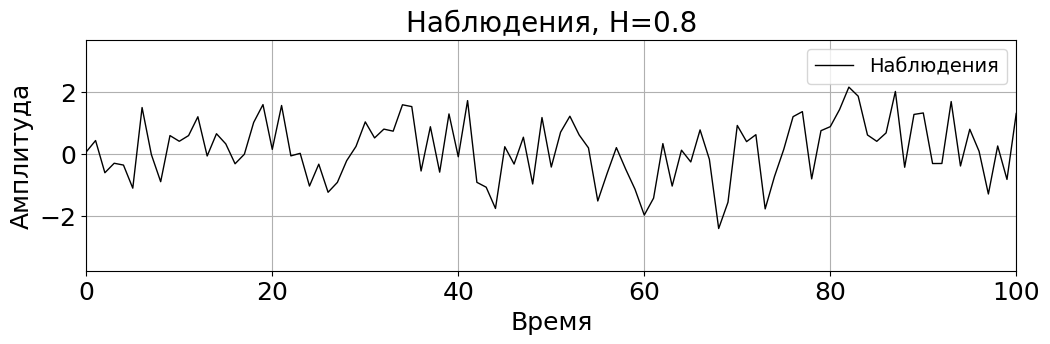

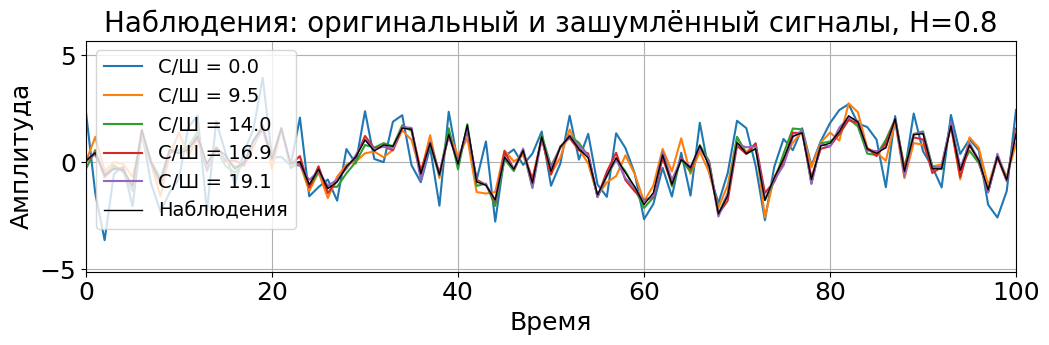

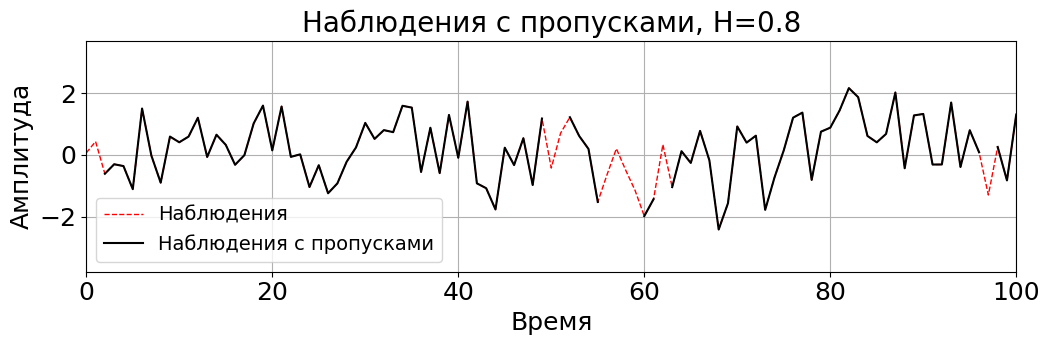

In [4]:
for h in [0.8]:
    plt.figure(figsize=(12, 3))
    generator = KasdinGenerator(h, length=TRJ_LEN)
    generated_signal = generator.get_full_sequence()
    gaps_signal, gaps = add_poisson_gaps(generated_signal, 0.1, 1.0)

    plt.plot(generated_signal, label=f"Наблюдения", color="black", linewidth=1)
    plt.xlabel("Время", fontsize=18)
    plt.ylabel("Амплитуда", fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(labelsize=18)
    plt.xlim(0, 100)
    plt.grid(True)
    plt.title(f"Наблюдения, H={h}", fontdict={"fontsize": 20})
    plt.savefig(f"research/out/signal_{h}-0-100.svg", bbox_inches="tight", dpi=300)
    plt.show()

    plt.figure(figsize=(12, 3))
    for i in range(1, 11, 2):
        noisy_signal, _ = add_noise(generated_signal, ratio=i)
        plt.plot(noisy_signal, label=f"С/Ш = {round(20 * np.log10(i), 1)}")

    plt.plot(generated_signal, label=f"Наблюдения", color="black", linewidth=1)
    plt.xlabel("Время", fontsize=18)
    plt.ylabel("Амплитуда", fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(labelsize=18)
    plt.grid(True)
    plt.xlim(0, 100)
    plt.title(
        f"Наблюдения: оригинальный и зашумлённый сигналы, H={h}",
        fontdict={"fontsize": 20},
    )
    plt.savefig(f"research/out/signal_noise{h}-0-100.svg", bbox_inches="tight", dpi=300)
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(
        generated_signal,
        label=f"Наблюдения",
        color="red",
        linestyle="--",
        linewidth=1,
    )
    plt.plot(gaps_signal, label=f"Наблюдения с пропусками", color="black")
    plt.xlabel("Время", fontsize=18)
    plt.ylabel("Амплитуда", fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(labelsize=18)
    plt.grid(True)
    plt.xlim(0, 100)
    plt.title(f"Наблюдения с пропусками, H={h}", fontdict={"fontsize": 20})
    plt.savefig(f"research/out/signal_gaps{h}-0-100.svg", bbox_inches="tight", dpi=300)
    plt.show()

## Restoring using the Kalman filter

Three options for configuring the Kalman filter are shown below.
Consider $\delta t=1$.

1. The first-order filter, hereinafter referred to as "I". 
In it, the matrix F is defined as a matrix with units on the main diagonal and $\delta t$.

$F = \begin{bmatrix} 1 & \delta t \\ 0 & 1 \end{bmatrix}$

2. The second-order filter, hereinafter referred to as "II". 
The values of the matrix F are selected in accordance with the Kasdin coefficients corresponding to the H of the input non-noisy signal.

$F = \begin{bmatrix} -A[1] - A[2] & A[2] * \delta t \\ \frac{-1 - A[1] - A[2]}{\delta t} & A[2] \end{bmatrix}$

3. The third-order filter, hereinafter referred to as "III". 
The values of the matrix F are selected in accordance with the Kasdin coefficients corresponding to the H of the input non-noisy signal.

$F = \begin{bmatrix} - A[1] - A[2] - A[3] & A[2] * A[2] + 2*A[3] & -A[3] \\ -1 - A[1] - A[2] - A[3] & A[2] + 2*A[3] & -A[3] \\ -1 - A[1] - A[2] - A[3] & -1 + A[2] + 2*A[3] & -A[3] \end{bmatrix}$

In [5]:
from StatTools.filters.kalman_filter import FractalKalmanFilter

In [ ]:
def recover_signal_by_libkalman(signal, original_signal, noise, dt: float, order: int):
    trj_len = signal.shape[0]
    if order == 3:
        f = FractalKalmanFilter(dim_x=3, dim_z=1)
        f.H = np.array([[1.0, 0.0, 0.0]])
    else:
        f = FractalKalmanFilter(dim_x=2, dim_z=1)
        f.H = np.array([[1.0, 0.0]])

    f.auto_configure(original_signal, noise, dt=dt, order=order)
    recovered_signal = np.zeros(trj_len)
    for k in range(1, trj_len):
        f.predict()
        if not np.isnan(signal[k]):
            f.update(signal[k])
        recovered_signal[k] = f.x[0].item()
    return recovered_signal

## Plot functions

In [ ]:
def plot_MSE_noise(
    original_signals,
    noisy_signals,
    generated_signals_1,
    generated_signals_2,
    generated_signals_3,
    noise_levels,
    h,
):
    n_ratios = len(noise_levels)
    n_samples = len(noisy_signals) // n_ratios

    noise_levels = np.array(noise_levels)

    mse_noisy = np.zeros((n_ratios, n_samples))
    mse_generated_1 = np.zeros((n_ratios, n_samples))
    mse_generated_2 = np.zeros((n_ratios, n_samples))
    mse_generated_3 = np.zeros((n_ratios, n_samples))

    for i in range(n_ratios):
        for j in range(n_samples):
            idx = i * n_samples + j
            mse_noisy[i, j] = np.mean((original_signals[idx] - noisy_signals[idx]) ** 2)
            mse_generated_1[i, j] = np.mean(
                (original_signals[idx] - generated_signals_1[idx]) ** 2
            )
            mse_generated_2[i, j] = np.mean(
                (original_signals[idx] - generated_signals_2[idx]) ** 2
            )
            mse_generated_3[i, j] = np.mean(
                (original_signals[idx] - generated_signals_3[idx]) ** 2
            )

    mse_noisy_mean = np.mean(mse_noisy, axis=1)
    mse_noisy_err = np.array(
        [
            mse_noisy_mean - np.percentile(mse_noisy, 5, axis=1),
            np.percentile(mse_noisy, 95, axis=1) - mse_noisy_mean,
        ]
    )
    mse_generated_1_mean = np.mean(mse_generated_1, axis=1)
    mse_generated_1_err = np.array(
        [
            mse_generated_1_mean - np.percentile(mse_generated_1, 5, axis=1),
            np.percentile(mse_generated_1, 95, axis=1) - mse_generated_1_mean,
        ]
    )

    mse_generated_2_mean = np.mean(mse_generated_2, axis=1)
    mse_generated_2_err = np.array(
        [
            mse_generated_2_mean - np.percentile(mse_generated_2, 5, axis=1),
            np.percentile(mse_generated_2, 95, axis=1) - mse_generated_2_mean,
        ]
    )

    mse_generated_3_mean = np.mean(mse_generated_3, axis=1)
    mse_generated_3_err = np.array(
        [
            mse_generated_3_mean - np.percentile(mse_generated_3, 5, axis=1),
            np.percentile(mse_generated_3, 95, axis=1) - mse_generated_3_mean,
        ]
    )

    plt.figure(figsize=(6, 6))
    plt.errorbar(
        noise_levels,
        mse_noisy_mean,
        yerr=mse_noisy_err,
        label="O",
        marker="o",
        capsize=5,
    )
    plt.errorbar(
        noise_levels,
        mse_generated_1_mean,
        yerr=mse_generated_1_err,
        label="I",
        marker="d",
        capsize=5,
    )
    plt.errorbar(
        noise_levels,
        mse_generated_2_mean,
        yerr=mse_generated_2_err,
        label="II",
        marker="s",
        capsize=5,
    )
    plt.errorbar(
        noise_levels,
        mse_generated_3_mean,
        yerr=mse_generated_3_err,
        label="III",
        marker="^",
        capsize=5,
    )

    plt.yscale("log")
    plt.ylim(10 ** (-1), 10**3)
    plt.xlabel("С/Ш, дБ", fontsize=20)
    plt.ylabel("СКО", fontsize=20)
    plt.title(
        f"Зависимость СКО от уровня шума,\n$\\hat{{H}}\\approx${h}",
        fontdict={"fontsize": 22},
    )
    plt.grid(True)
    plt.tick_params(labelsize=20)
    plt.legend(fontsize=20)
    os.makedirs("research/out", exist_ok=True)
    plt.savefig(f"research/out/MSE_H_noise_{h}.svg", bbox_inches="tight")
    plt.show()

In [ ]:
def plot_MSE_H_noise(
    original_signals,
    noisy_signals,
    generated_signals_1,
    generated_signals_2,
    generated_signals_3,
    snr_db,
    h_list,
):
    """All orders data, diffetent H, one SNR [noise]"""
    n_h = len(h_list)
    n_samples = len(noisy_signals) // n_h
    h_list = np.array(h_list)

    mse_noisy = np.zeros((n_h, n_samples))
    mse_generated_1 = np.zeros((n_h, n_samples))
    mse_generated_2 = np.zeros((n_h, n_samples))
    mse_generated_3 = np.zeros((n_h, n_samples))

    for i in range(n_h):
        for j in range(n_samples):
            idx = i * n_samples + j
            mse_noisy[i, j] = np.mean((original_signals[idx] - noisy_signals[idx]) ** 2)
            mse_generated_1[i, j] = np.mean(
                (original_signals[idx] - generated_signals_1[idx]) ** 2
            )
            mse_generated_2[i, j] = np.mean(
                (original_signals[idx] - generated_signals_2[idx]) ** 2
            )
            mse_generated_3[i, j] = np.mean(
                (original_signals[idx] - generated_signals_3[idx]) ** 2
            )

    mse_noisy_mean = np.mean(mse_noisy, axis=1)
    mse_noisy_err = np.array(
        [
            mse_noisy_mean - np.percentile(mse_noisy, 5, axis=1),
            np.percentile(mse_noisy, 95, axis=1) - mse_noisy_mean,
        ]
    )

    mse_generated_1_mean = np.mean(mse_generated_1, axis=1)
    mse_generated_1_err = np.array(
        [
            mse_generated_1_mean - np.percentile(mse_generated_1, 5, axis=1),
            np.percentile(mse_generated_1, 95, axis=1) - mse_generated_1_mean,
        ]
    )

    mse_generated_2_mean = np.mean(mse_generated_2, axis=1)
    mse_generated_2_err = np.array(
        [
            mse_generated_2_mean - np.percentile(mse_generated_2, 5, axis=1),
            np.percentile(mse_generated_2, 95, axis=1) - mse_generated_2_mean,
        ]
    )

    mse_generated_3_mean = np.mean(mse_generated_3, axis=1)
    mse_generated_3_err = np.array(
        [
            mse_generated_3_mean - np.percentile(mse_generated_3, 5, axis=1),
            np.percentile(mse_generated_3, 95, axis=1) - mse_generated_3_mean,
        ]
    )

    plt.figure(figsize=(6, 6))
    plt.errorbar(
        h_list, mse_noisy_mean, yerr=mse_noisy_err, label="O", marker="o", capsize=5
    )
    plt.errorbar(
        h_list,
        mse_generated_1_mean,
        yerr=mse_generated_1_err,
        label="I",
        marker="d",
        capsize=5,
    )
    plt.errorbar(
        h_list,
        mse_generated_2_mean,
        yerr=mse_generated_2_err,
        label="II",
        marker="s",
        capsize=5,
    )
    plt.errorbar(
        h_list,
        mse_generated_3_mean,
        yerr=mse_generated_3_err,
        label="III",
        marker="^",
        capsize=5,
    )
    plt.tick_params(labelsize=20)
    plt.legend(fontsize=20)
    plt.yscale("log")
    plt.xlabel("H", fontsize=20)
    plt.ylabel("С/Ш", fontsize=20)
    plt.title(f"Зависимость СКО от H, С/Ш={snr_db:.1f}", fontdict={"fontsize": 22})
    plt.grid(True)
    plt.legend()
    plt.savefig(f"research/out/mse-dep_on_h-noise{snr_db:.0f}.svg", bbox_inches="tight")
    plt.show()

In [ ]:
def plot_MSE_gaps(
    mse_generated_1_total,
    mse_generated_2_total,
    mse_generated_3_total,
    snr_db,
    labels_x,
):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.boxplot(
        mse_generated_1_total.T,
        tick_labels=labels_x,
        patch_artist=True,
        flierprops={"markeredgecolor": "tab:orange"},
        whiskerprops={"color": "tab:orange", "linestyle": "--"},
        capprops={"color": "tab:orange"},
        boxprops={"facecolor": "tab:orange", "alpha": 0.5, "edgecolor": "tab:orange"},
        medianprops={"color": "tab:orange"},
        label="I",
    )

    ax.boxplot(
        mse_generated_2_total.T,
        tick_labels=labels_x,
        patch_artist=True,
        flierprops={"markeredgecolor": "tab:green"},
        whiskerprops={"color": "tab:green", "linestyle": "--"},
        capprops={"color": "tab:green"},
        boxprops={"facecolor": "tab:green", "alpha": 0.5, "edgecolor": "tab:green"},
        medianprops={"color": "tab:green"},
        label="II",
    )

    ax.boxplot(
        mse_generated_3_total.T,
        tick_labels=labels_x,
        patch_artist=True,
        flierprops={"markeredgecolor": "tab:red"},
        whiskerprops={"color": "tab:red", "linestyle": "--"},
        capprops={"color": "tab:red"},
        boxprops={"facecolor": "tab:red", "alpha": 0.5, "edgecolor": "tab:red"},
        medianprops={"color": "tab:red"},
        label="III",
    )

    ax.set_title(
        "Зависимость СКО от H для сигнала с пропусками", fontdict={"fontsize": 22}
    )
    ax.set_xlabel("H", fontsize=20)
    ax.set_ylabel("СКО", fontsize=20)

    lgd = plt.legend(
        loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3, fontsize=20
    )
    plt.grid()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"research/out/mse-dep_on_h-gaps.svg", bbox_inches="tight")
    plt.show()

In [23]:
def plot_signals_with_label(
    Y,
    Z,
    recovered_Z_1,
    recovered_Z_2,
    recovered_Z_3,
    snr=None,
    plot_len=None,
    signal_label="с шумом",
):
    plt.figure(figsize=(16, 5))
    if plot_len is None:
        plot_len = len(Y)

    plt.plot(Z[:plot_len], label=f"Наблюдения {signal_label}")
    plt.plot(Y[:plot_len], label=f"Наблюдения", color="black")
    plt.plot(recovered_Z_1[:plot_len], label=f"Выход фильтра (I)")
    plt.plot(recovered_Z_2[:plot_len], label=f"Выход фильтра (II)")
    plt.plot(recovered_Z_3[:plot_len], label=f"Выход фильтра (III)")

    lgd = plt.legend(
        loc="lower center", bbox_to_anchor=(0.5, -0.46), ncol=3, fontsize=20
    )
    if snr is not None:
        plt.title(
            f"Фильтрация сигнала {signal_label},\n $\\hat{{H}}=${h}, СО(I)={np.nanstd(Y - recovered_Z_1):.3f}, СО(II)={np.nanstd(Y - recovered_Z_2):.3f}, СО(III)={np.nanstd(Y - recovered_Z_3):.3f}",
            fontdict={"fontsize": 22},
        )
    else:
        plt.title(
            f"Фильтрация сигнала {signal_label},\n $\\hat{{H}}=${h}, С/Ш={snr}, СО(I)={np.nanstd(Y - recovered_Z_1):.3f}, СО(II)={np.nanstd(Y - recovered_Z_2):.3f}, СО(III)={np.nanstd(Y - recovered_Z_3):.3f}",
            fontdict={"fontsize": 22},
        )

    plt.xlabel("Время", fontsize=20)
    plt.ylabel("Амплитуда", fontsize=20)
    plt.tick_params(labelsize=20)
    plt.grid(True)
    plt.show()

## Results

The figure below presents a comparison of the effectiveness of different signal recovery methods under varying noise levels and original signal parameters.

For each value of the Hurst parameter, a signal is generated. Various noise levels are set from -20 to 10 dB. For each noise level, 15 noisy versions of the original signal are created and restored using three different methods (designated as I, II, and III) using the Kalman filter. For each noise level, the error (MSE) between the original and noisy signals, the original and each of the three reconstructed signals is calculated with a 90% confidence interval (5th and 95th percentiles).

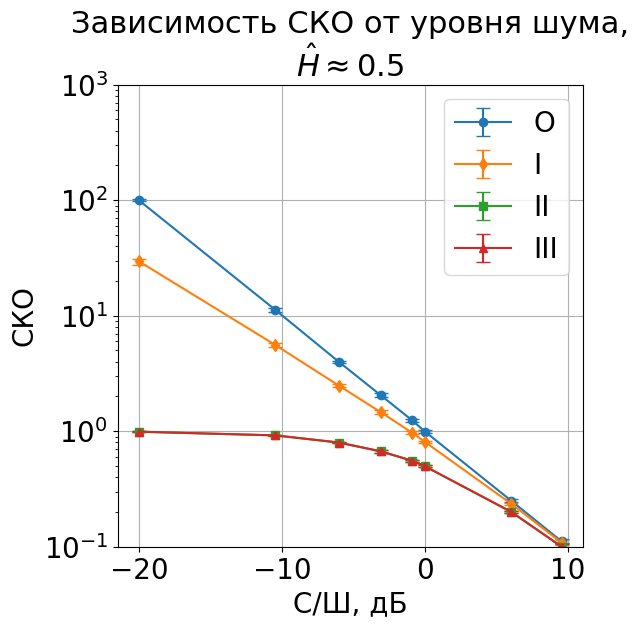

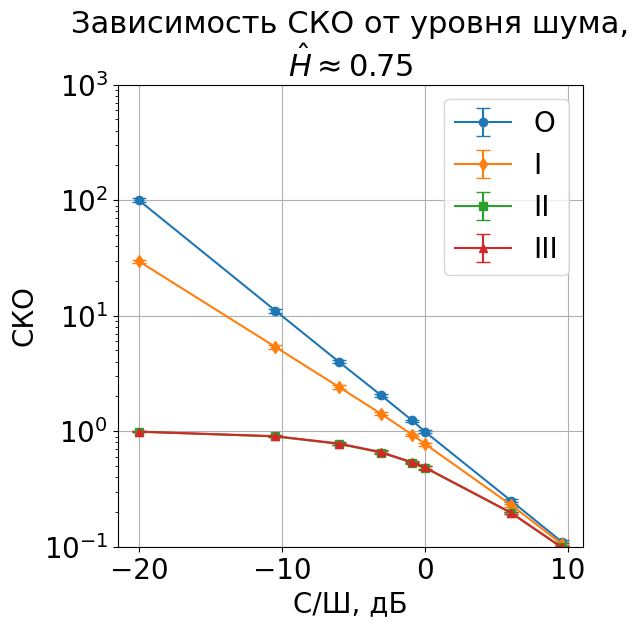

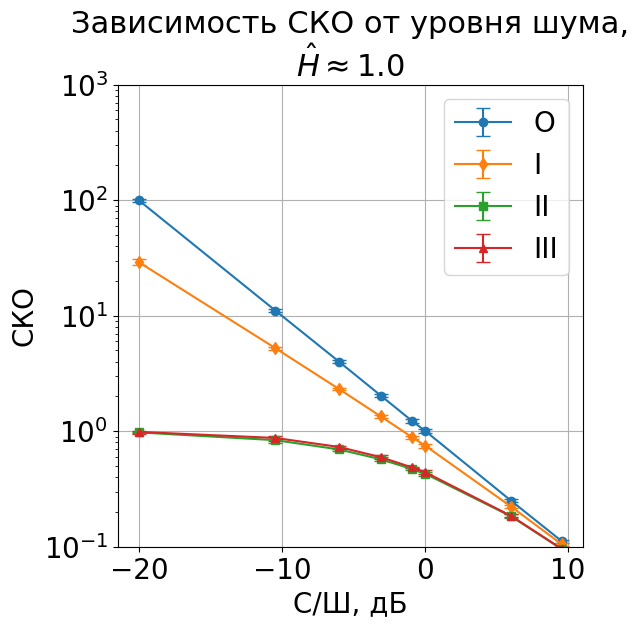

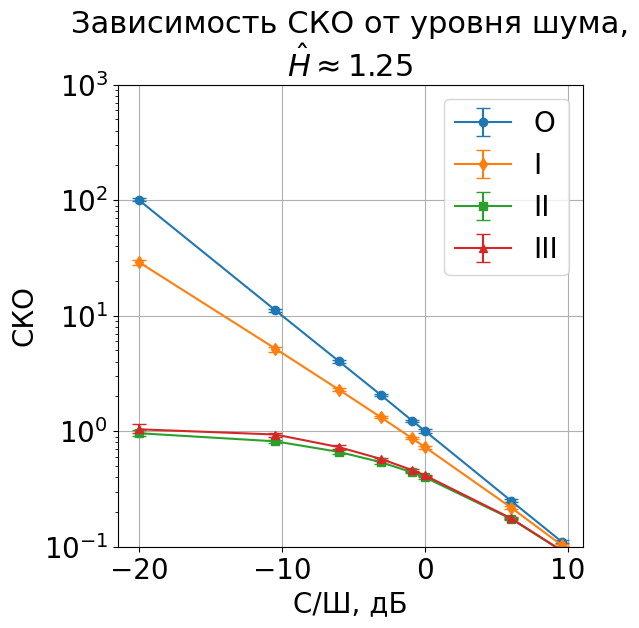

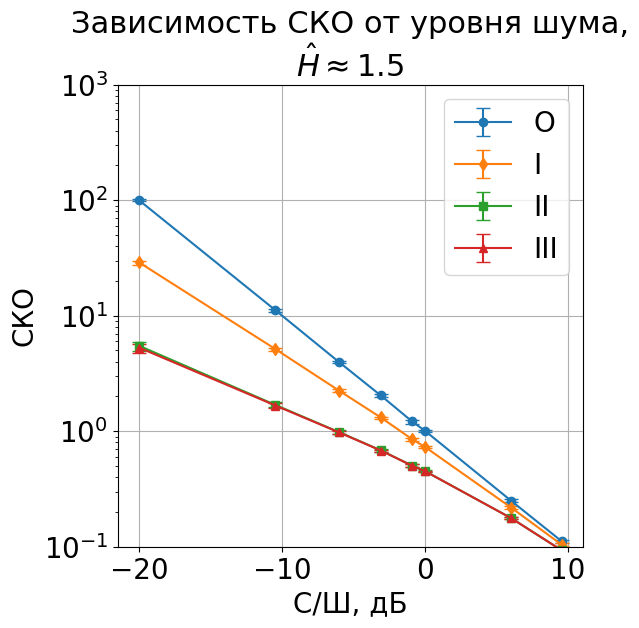

In [ ]:
for h in H_LIST:
    generator = KasdinGenerator(h, length=TRJ_LEN)
    original_signal = generator.get_full_sequence()
    n = 15

    noise_ratios = np.array([0.1, 0.3, 0.5, 0.7, 0.9] + list(range(1, 4)))
    snr_db = 20 * np.log10(noise_ratios)
    num_ratios = len(noise_ratios)
    total_signals = n * num_ratios

    original_signals_total = np.tile(original_signal, (total_signals, 1))
    noisy_signals_total = np.zeros((total_signals, TRJ_LEN))
    generated_signals_1 = np.zeros((total_signals, TRJ_LEN))
    generated_signals_2 = np.zeros((total_signals, TRJ_LEN))
    generated_signals_3 = np.zeros((total_signals, TRJ_LEN))

    for i, noise_ratio in enumerate(noise_ratios):
        for j in range(n):
            idx = i * n + j

            signal_Z, noise = add_noise(original_signal, noise_ratio)
            noisy_signals_total[idx] = signal_Z

            recovered_Z_1 = recover_signal_by_libkalman(
                signal_Z, original_signal, noise, 1, 1
            )
            generated_signals_1[idx] = recovered_Z_1

            recovered_Z_2 = recover_signal_by_libkalman(
                signal_Z, original_signal, noise, 1, 2
            )
            generated_signals_2[idx] = recovered_Z_2

            recovered_Z_3 = recover_signal_by_libkalman(
                signal_Z, original_signal, noise, 1, 3
            )
            generated_signals_3[idx] = recovered_Z_3

    plot_MSE_noise(
        original_signals_total,
        noisy_signals_total,
        generated_signals_1,
        generated_signals_2,
        generated_signals_3,
        snr_db,
        h,
    )

In [ ]:
n = 15
num_h = len(H_LIST)
total_signals = n * num_h
noise_ratio = 0.1
snr_db = 20 * np.log10(noise_ratio)

original_signals_total = np.zeros((total_signals, TRJ_LEN))
noisy_signals_total = np.zeros((total_signals, TRJ_LEN))
generated_signals_1 = np.zeros((total_signals, TRJ_LEN))
generated_signals_2 = np.zeros((total_signals, TRJ_LEN))
generated_signals_3 = np.zeros((total_signals, TRJ_LEN))

for i, h in enumerate(H_LIST):
    generator = KasdinGenerator(h, length=TRJ_LEN)
    original_signal = generator.get_full_sequence()

    for j in range(n):
        idx = i * n + j
        original_signals_total[idx] = original_signal

        signal_Z, noise = add_noise(original_signal, noise_ratio)
        noisy_signals_total[idx] = signal_Z

        recovered_Z_1 = recover_signal_by_libkalman(
            signal_Z, original_signal, noise, 1, 1
        )
        generated_signals_1[idx] = recovered_Z_1

        recovered_Z_2 = recover_signal_by_libkalman(
            signal_Z, original_signal, noise, 1, 2
        )
        generated_signals_2[idx] = recovered_Z_2

        recovered_Z_3 = recover_signal_by_libkalman(
            signal_Z, original_signal, noise, 1, 3
        )
        generated_signals_3[idx] = recovered_Z_3

The figure summarizes the results for a fixed noise level of 20 dB across different Hurst parameter (H) values.

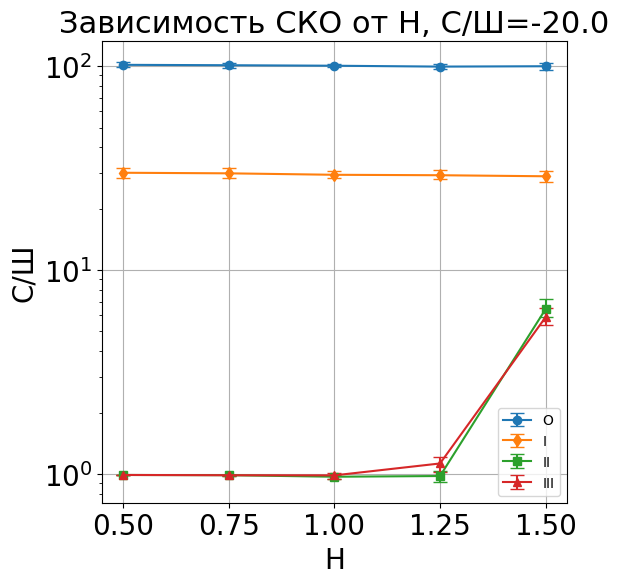

In [13]:
plot_MSE_H_noise(
    original_signals_total,
    noisy_signals_total,
    generated_signals_1,
    generated_signals_2,
    generated_signals_3,
    snr_db,
    H_LIST,
)

In [ ]:
gap_rate = 0.1
length_rate = 1.0
total_signals = 10
x = []
noise = np.zeros(TRJ_LEN)
mse_generated_1_total = np.zeros((len(H_LIST), total_signals))
mse_generated_1_mean_total = np.zeros(len(H_LIST))
mse_generated_1_err_total = np.zeros((len(H_LIST), 2))

mse_generated_2_total = np.zeros((len(H_LIST), total_signals))
mse_generated_2_mean_total = np.zeros(len(H_LIST))
mse_generated_2_err_total = np.zeros((len(H_LIST), 2))

mse_generated_3_total = np.zeros((len(H_LIST), total_signals))
mse_generated_3_mean_total = np.zeros(len(H_LIST))
mse_generated_3_err_total = np.zeros((len(H_LIST), 2))

for i, h in enumerate(H_LIST):
    generator = KasdinGenerator(h, length=TRJ_LEN)
    original_signal = generator.get_full_sequence()
    dfa = DFA(original_signal)
    x.append(round(dfa.find_h(), 2))

    original_signals_total = np.tile(original_signal, (total_signals, 1))
    gap_signals_total = np.zeros((total_signals, TRJ_LEN))
    generated_signals_1_total = np.zeros((total_signals, TRJ_LEN))
    generated_signals_2_total = np.zeros((total_signals, TRJ_LEN))
    generated_signals_3_total = np.zeros((total_signals, TRJ_LEN))

    for j in range(total_signals):
        signal_Z, gaps = add_poisson_gaps(original_signal, gap_rate, length_rate)
        gap_signals_total[j] = signal_Z

        recovered_Z_1 = recover_signal_by_libkalman(
            signal_Z, original_signal, noise, 1, 1
        )
        generated_signals_1_total[j] = recovered_Z_1

        recovered_Z_2 = recover_signal_by_libkalman(
            signal_Z, original_signal, noise, 1, 2
        )
        generated_signals_2_total[j] = recovered_Z_2

        recovered_Z_3 = recover_signal_by_libkalman(
            signal_Z, original_signal, noise, 1, 3
        )
        generated_signals_3_total[j] = recovered_Z_3

    n_samples = len(original_signals_total)

    mse_generated_1 = np.zeros(n_samples)
    mse_generated_2 = np.zeros(n_samples)
    mse_generated_3 = np.zeros(n_samples)

    for j in range(n_samples):
        mse_generated_1[j] = np.nanmean(
            (original_signals_total[j] - generated_signals_1_total[j]) ** 2
        )
        mse_generated_2[j] = np.nanmean(
            (original_signals_total[j] - generated_signals_2_total[j]) ** 2
        )
        mse_generated_3[j] = np.nanmean(
            (original_signals_total[j] - generated_signals_3_total[j]) ** 2
        )

    mse_generated_1_mean = np.nanmean(mse_generated_1)
    mse_generated_1_err = np.array(
        [
            mse_generated_1_mean - np.nanpercentile(mse_generated_1, 5),
            np.nanpercentile(mse_generated_1, 95) - mse_generated_1_mean,
        ]
    )

    mse_generated_2_mean = np.nanmean(mse_generated_2)
    mse_generated_2_err = np.array(
        [
            mse_generated_2_mean - np.nanpercentile(mse_generated_2, 5),
            np.nanpercentile(mse_generated_2, 95) - mse_generated_2_mean,
        ]
    )

    mse_generated_3_mean = np.nanmean(mse_generated_3)
    mse_generated_3_err = np.array(
        [
            mse_generated_3_mean - np.nanpercentile(mse_generated_3, 5),
            np.nanpercentile(mse_generated_3, 95) - mse_generated_3_mean,
        ]
    )

    mse_generated_1_mean_total[i] = mse_generated_1_mean
    mse_generated_2_mean_total[i] = mse_generated_2_mean
    mse_generated_3_mean_total[i] = mse_generated_3_mean

    mse_generated_1_err_total[i] = mse_generated_1_err
    mse_generated_2_err_total[i] = mse_generated_2_err
    mse_generated_3_err_total[i] = mse_generated_3_err

    mse_generated_1_total[i] = mse_generated_1
    mse_generated_2_total[i] = mse_generated_2
    mse_generated_3_total[i] = mse_generated_3

The figure below extends the previous noise analysis by examining how different Kalman filter methods handle another common data problem – gaps and how their performance depends on the Hurst parameter. The gap occurrence frequency is set to 0.1, and the total number of test signals for each H is 10. Additionally, gap lengths follow a Poisson distribution.

After signal generation we restore it using three Kalman filter methodsmethods. For each method, the MSE between the reconstructed and the original signal is calculated and plotted by boxplots. 

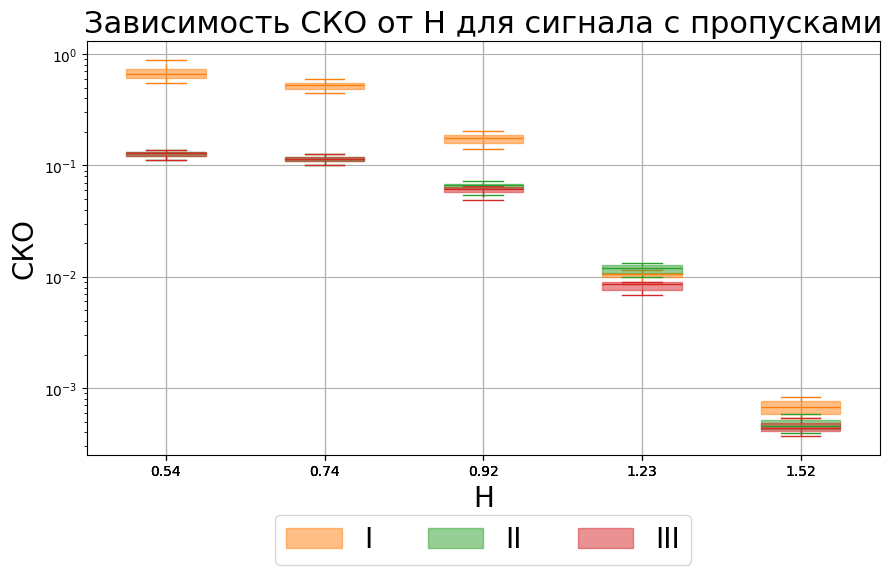

In [15]:
plot_MSE_gaps(
    mse_generated_1_total, mse_generated_2_total, mse_generated_3_total, snr_db, x
)

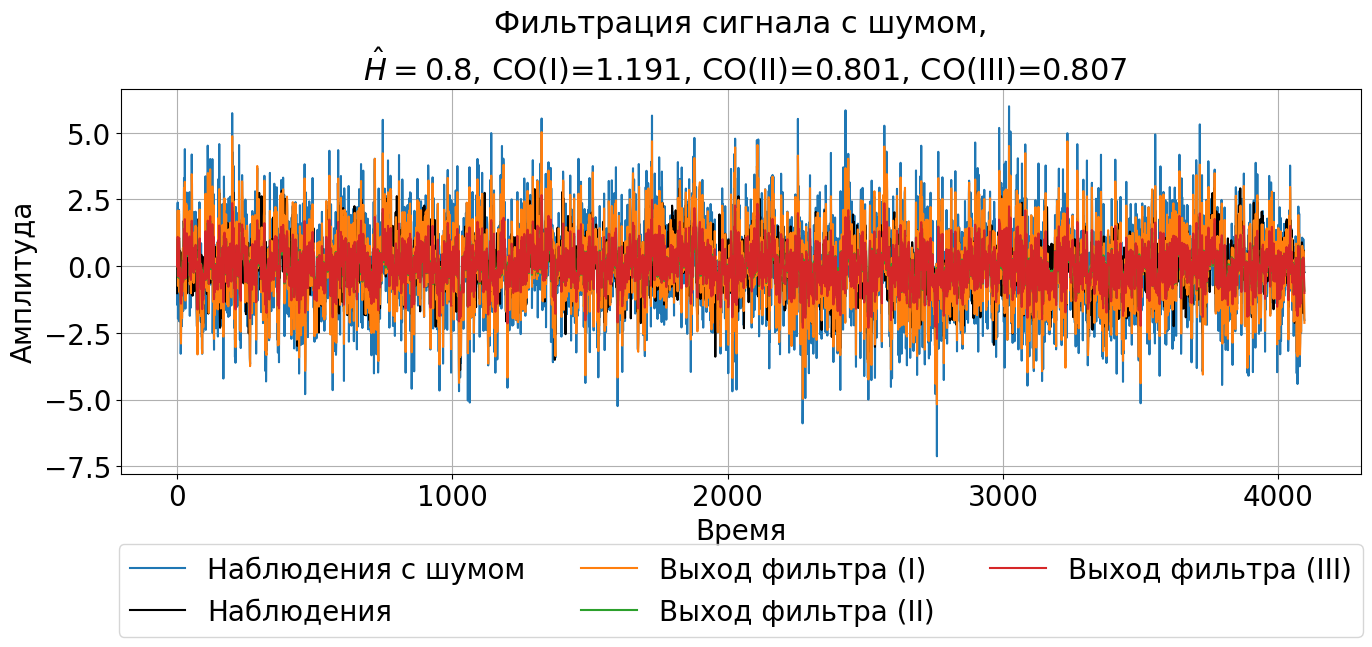

In [24]:
h = 0.8
generator = KasdinGenerator(h, length=TRJ_LEN)
original_signal = generator.get_full_sequence()
n = 1

noise_ratios = np.array([0.7])
num_ratios = len(noise_ratios)
total_signals = n * num_ratios

original_signals_total = np.tile(original_signal, (total_signals, 1))

for i, noise_ratio in enumerate(noise_ratios):
    snr = round(20 * np.log10(noise_ratio), 2)
    for j in range(n):
        idx = i * n + j

        signal_Z, noise = add_noise(original_signal, noise_ratio)

        recovered_Z_1 = recover_signal_by_libkalman(
            signal_Z, original_signal, noise, 1, 1
        )
        recovered_Z_2 = recover_signal_by_libkalman(
            signal_Z, original_signal, noise, 1, 2
        )
        recovered_Z_3 = recover_signal_by_libkalman(
            signal_Z, original_signal, noise, 1, 3
        )

    plot_signals_with_label(
        original_signals_total[idx],
        signal_Z,
        recovered_Z_1,
        recovered_Z_2,
        recovered_Z_3,
        snr,
        signal_label="с шумом",
    )

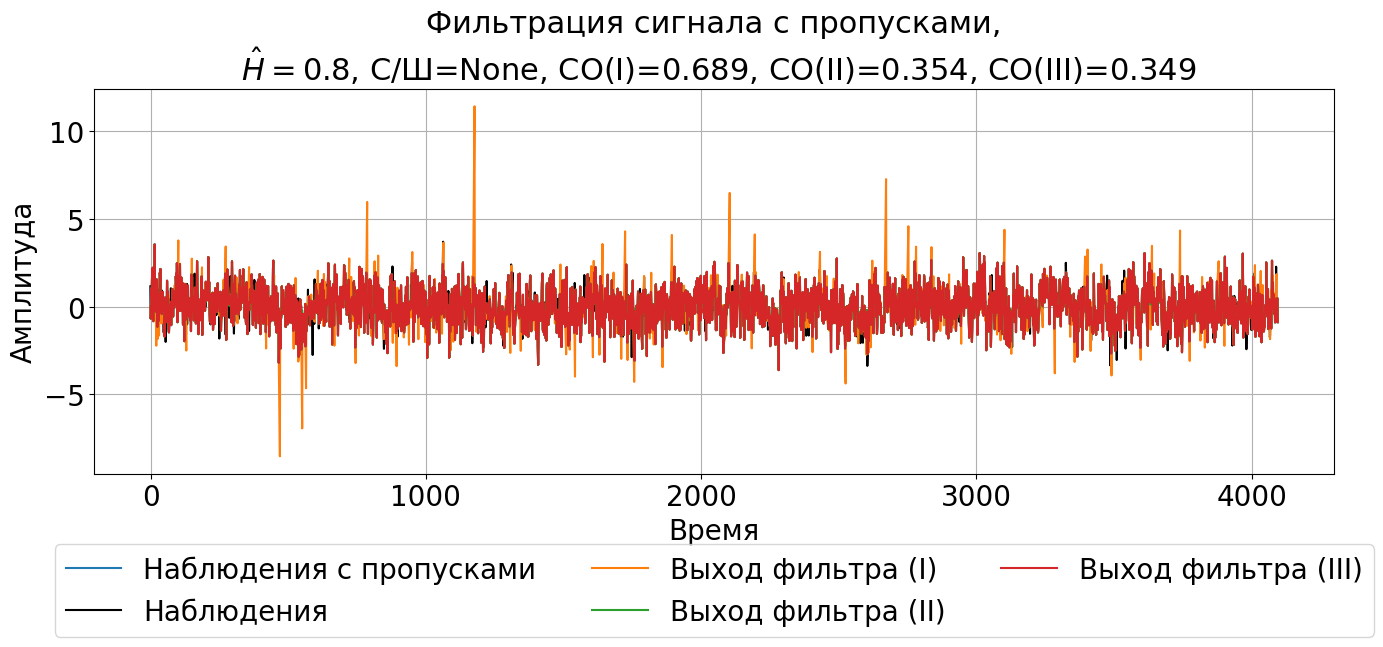

In [25]:
h = 0.8
generator = KasdinGenerator(h, length=TRJ_LEN)
original_signal = generator.get_full_sequence()
n = 1
total_signals = n
noise = np.zeros(TRJ_LEN)
original_signals_total = np.tile(original_signal, (total_signals, 1))

for j in range(n):
    idx = i * n + j

    signal_Z, gaps = add_poisson_gaps(original_signal, 0.1, 1)

    recovered_Z_1 = recover_signal_by_libkalman(signal_Z, original_signal, noise, 1, 1)
    recovered_Z_2 = recover_signal_by_libkalman(signal_Z, original_signal, noise, 1, 2)
    recovered_Z_3 = recover_signal_by_libkalman(signal_Z, original_signal, noise, 1, 3)

plot_signals_with_label(
    original_signals_total[idx],
    signal_Z,
    recovered_Z_1,
    recovered_Z_2,
    recovered_Z_3,
    signal_label="с пропусками",
)